# Data Analysis
Analysis of line scans taken at the beam. See the `README` in the `Experimental Data` folder.

In [84]:
import utils
from importlib import reload
import itertools

import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import AgglomerativeClustering

from scipy.special import gammainc
from scipy.interpolate import interp1d
from scipy.optimize import basinhopping
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import chisquare
from scipy.special import comb

utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Load Simulated Reference Data

In [3]:
exp = parse_file('Reference Data/As_exp_standards_normalized_same_params.dat')
sim = parse_file('Reference Data/As_edge_sim_standards_phases_normalized_same_params.dat')
defect = parse_file('Reference Data/As_defects_normalized.dat')

energy = np.array(sim['X1'], dtype=float)

sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

defect_data_columns = [colm for colm in defect.columns if len(colm.replace('X', '')) > 3]
Defect_Refs = np.array(defect[defect_data_columns], dtype=float).T

refs = np.concatenate((Sim_Refs, Exp_Refs, Defect_Refs), axis=0)

Energy = np.linspace(11863, 11915, 5201)
Energy_exp = np.array([11866.5, 11870., 11873.5, 11876.5, 11879., 11885.5, 11900., 11904., 11909.5])

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)
Refs_exp = interperlator(Energy_exp)
print(Refs.shape)

print(f"Resolution: {Energy[1] - Energy[0]}")

data_columns = sim_data_columns + exp_data_columns + defect_data_columns

sorted_indices = [i[0] for i in sorted(enumerate(data_columns), key=lambda x:x[1])]
temp_dc = [data_columns[i] for i in sorted_indices]
temp_refs = np.array([Refs[i] for i in sorted_indices])

Refs = temp_refs
data_columns = temp_dc

segments = [0, 8, 11, 15, 18, 23, 31, 34]
sample_sizes = [1, 2, 1, 2, 3, 5, 2]
cut_sizes = [segments[i + 1] - segments[i] for i in range(len(segments) - 1)]

(34, 5201)
Resolution: 0.010000000000218279


# Load Experimental References

In [4]:
standard_fnames = ['lineAs_metal_scan006.mda.csv', 'lineCd3As2_scan008.mda.csv',
                   'lineAs2O3_scan009.mda.csv', 'lineAs3Te2_scan011.mda.csv']
standards = ['As metal', '$Cd_3As_2$', '$As_2O_3$', '$As_3Te_2$']
dfs = [pd.read_csv(f'Experimental data/Arsenic standards/{filename}') for filename in standard_fnames]
dfs = [preprocess_df(df) for df in dfs]

In [5]:
verbose = False
if verbose:
    cuts = get_cuts(data_columns, segments, sample_sizes)
    for i, cut in enumerate(cuts):
        print(f'Segment {i + 1}: Sample size {sample_sizes[i]}')
        for name in cut:
            print(name)
        print()

## Visualize Simulated References

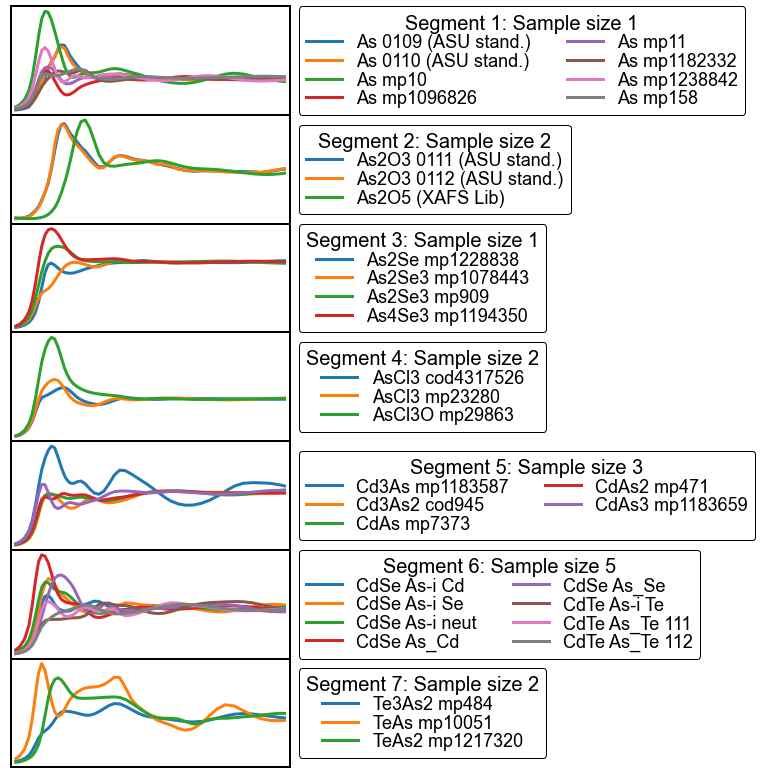

In [6]:
cut_names = get_cuts(data_columns, segments, sample_sizes)
cut_Refs = get_cuts(Refs, segments, sample_sizes)
num_cuts = len(cut_names)

fig, axes = plt.subplots(figsize=(5, 2 * num_cuts), nrows=num_cuts)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, cut in enumerate(cut_Refs):
    ax = axes[i]
    for j, ref in enumerate(cut):
        label = f'{cut_names[i][j]}'
        ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20((j*2)/19), label=label, alpha=1.)
    if len(cut) >= 5:
        ncol = 2
    else:
        ncol = 1
    ax.legend(fontsize=18, framealpha=1., labelspacing=0.04, title_fontsize=20,
              loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol, edgecolor='k',
              title=f'Segment {i + 1}: Sample size {sample_sizes[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(11862, 11916)
    set_spine_width(ax, width=2)

plt.savefig(f'Figures/references_by_cut.png', dpi=1500, transparent=True, bbox_inches='tight')

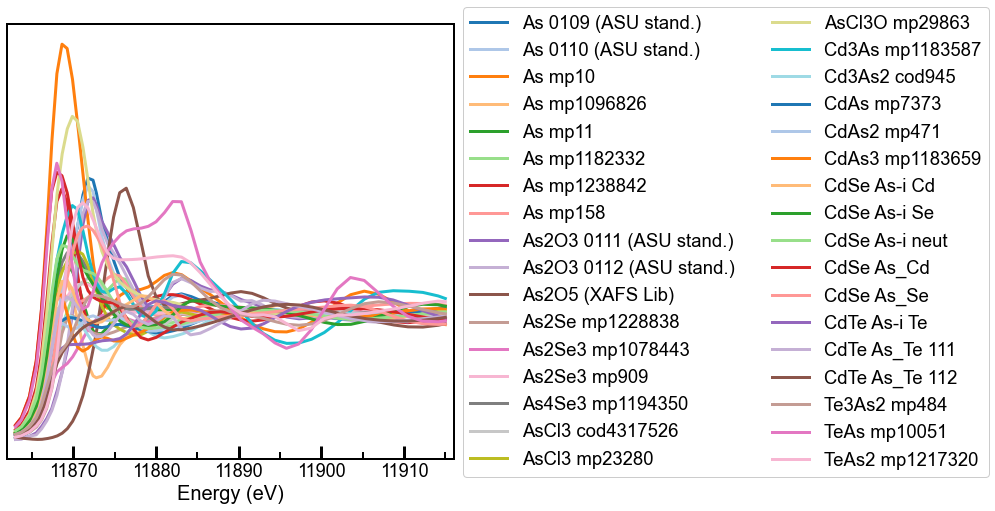

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=18.5, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
ax.set_xlim(11862, 11916)
set_spine_width(ax, width=2)
plt.savefig(f'Figures/references_with_defects.png', dpi=800, transparent=True, bbox_inches='tight')

## Visualize Experimental references

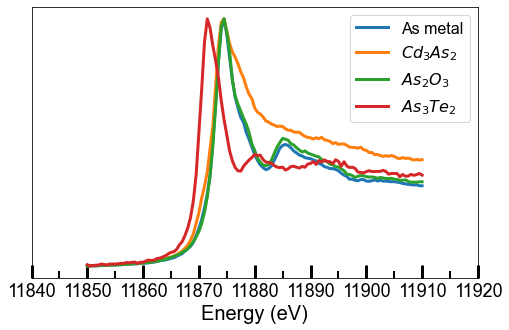

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, label in enumerate(standards):
    x, y = get_xy_from_colms(dfs[i], 'Energy (keV)', 'I_0 (a.u.)')
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab20(i*2), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

## Energy shift
A 2.73 eV energy shift will be applied to all simulated references so that is is aligned with the new experimental data.

In [9]:
energy = energy + 2.74
exp_energy = np.array(dfs[0]['Energy (keV)'], dtype=float)

bool_arr = exp_energy * 1000 > 11865
Exp_Energy = exp_energy[bool_arr] * 1000
Energy = Exp_Energy.copy()

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)

delta E: 0.0
alpha: 0.38808721369721544


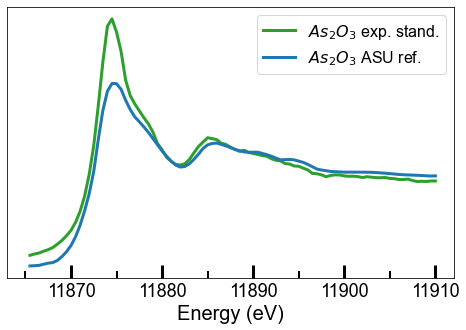

In [10]:
def spectral_loss(x, spectrum, target, metric):
    return eval(metric)(x*spectrum, target)

def get_scale(spectrum, target, metric='mean_absolute_error'):
    alpha0 = 0.1
    alpha = minimize(spectral_loss, alpha0, args=(spectrum, target, metric))['x']
    return alpha

fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[2] + ' exp. stand.'
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=label)

x2 = Energy
y2 = Refs[24]
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(f'delta E: {delta_E}')

alpha = get_scale(y2, y1)
print(f'alpha: {alpha[0]}')
y2 = alpha * y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
ax.set_xlim(11863, 11912)
plt.savefig('Figures/As2O3_exp_comparison.png', dpi=800, transparent=True)

# Visualize the Experimental Data

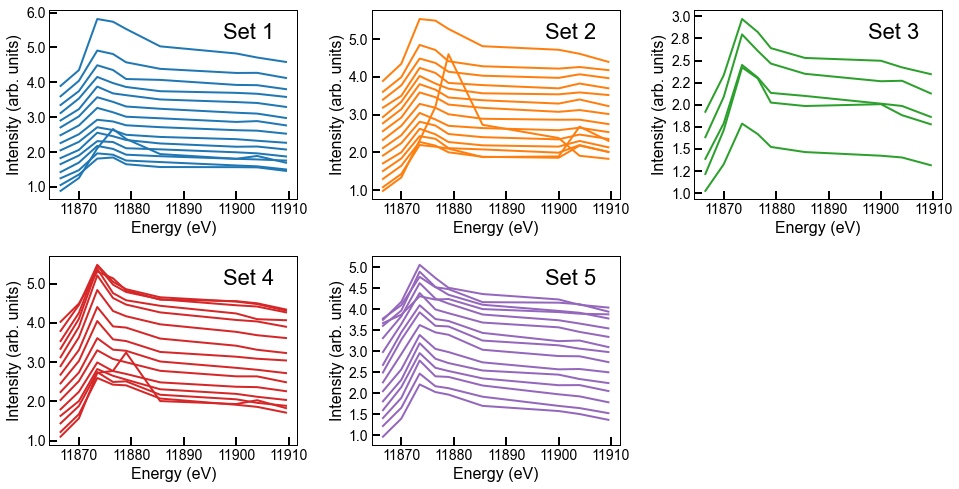

In [11]:
Energies = np.array([11.8665, 11.87, 11.8735, 11.8765, 11.879,
                     11.8855, 11.9, 11.904, 11.9095])
DATA = get_all_data(Energies)
# data is a list (by set) of a list (by pixel number) of dictaries (by xy pos)

nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(16, 8), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for Set in range(1, 7):
    row = (Set - 1) // ncols
    colm = (Set - 1) % ncols
    ax = axes[row, colm]
    if Set <= 5:
        setdata = DATA[Set] 
        for i, pt in enumerate(setdata):
            intensity = np.array(pt['I'], dtype=float)
            ax.plot(pt['E'], intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
        ax.annotate(f'Set {Set}', (0.7, 0.85), xycoords='axes fraction', fontsize=22)
        ax.set_ylabel("Intensity (arb. units)", fontsize=16)        
        ax.set_xlabel("Energy (eV)", fontsize=16)
        ax.tick_params(direction='in', width=2, length=8, which='major', axis='both')
        
        ax.set_xticks(np.array(ax.get_xticks())[1:-1])
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=14)
        
        ax.set_yticks(np.array(ax.get_yticks())[1:-1])
        ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=14)
        
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        set_spine_width(ax, width=1.)
    else:
        ax.axis('off')

plt.savefig('Figures/linescans.png', dpi=800, transparent=True, bbox_inches='tight')

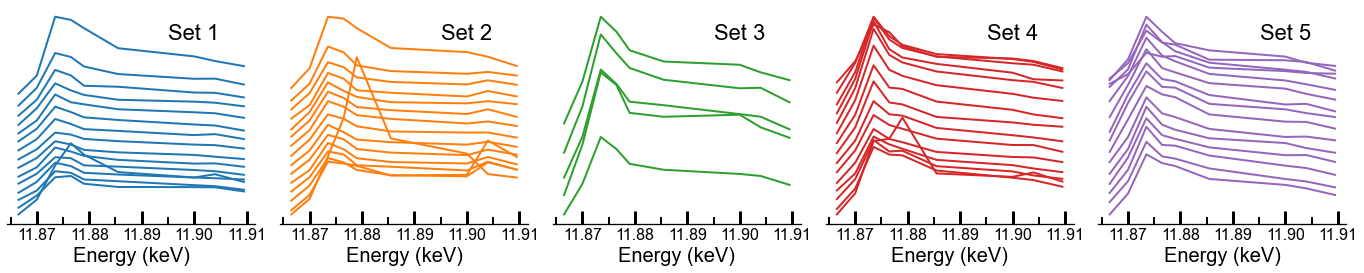

In [12]:
ncols = 5
fig, axes = plt.subplots(figsize=(24, 4), nrows=1, ncols=ncols)
plt.subplots_adjust(wspace=0.1, hspace=0.)

for Set in range(1, 6):
    colm = (Set - 1) % ncols
    ax = axes[colm]
    
    setdata = DATA[Set] 
    for i, pt in enumerate(setdata):
        intensity = np.array(pt['I'], dtype=float)
        ax.plot(np.array(pt['E']) / 1000, intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
    ax.annotate(f'Set {Set}', (0.65, 0.85), xycoords='axes fraction', fontsize=22)
    
    ax.set_yticks([])
    ax.set_xlabel('Energy (keV)', fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.005))
    ax.xaxis.set_major_locator(MultipleLocator(0.010))
    ax.tick_params(direction='in', width=3, length=13, which='major', labelsize=16)
    ax.tick_params(direction='in', width=2, length=7, which='minor')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    set_spine_width(ax, width=1.3)
    turn_off_spines(ax, spines=['top', 'left', 'right'])

plt.savefig('Figures/linescans_smushed.png', dpi=800, transparent=True, bbox_inches='tight')

# Removing similar references: Another feature elimination task...

High LCF errors arise if the basis set is non linearly independent.

## Monte Carlo decoposition

In [13]:
subset_size = None

cut_indices = get_cuts(np.arange(len(Refs)), segments, sample_sizes)
cut_to_idx_map = {cut_num: cut_idxs for cut_num, cut_idxs in enumerate(cut_indices)}

#scores, selected_indices = sample_basis(Refs, 250, subset_size, segments=segments, sample_sizes=sample_sizes,
#                                        cut_sizes=cut_sizes, cut_to_idx_map=cut_to_idx_map,
#                                        monte_carlo=True)

`[ 2  9 10 12 17 16 18 19 20 25 27 23 26 28 32 33]`

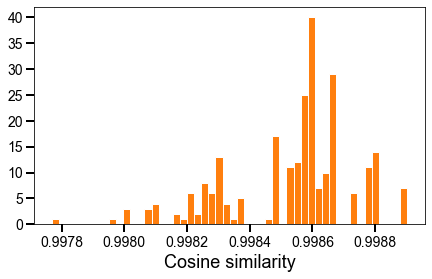

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(scores, bins=50, ec='w', fc=plt.cm.tab20(2))
ax.set_xlabel('Cosine similarity', fontsize=18)
ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.show()

In [17]:
for i in range(len(selected_indices)):
    print(i, data_columns[selected_indices[i]])

0 As mp10
1 As2O3 0112 (ASU stand.)
2 As2O5 (XAFS Lib)
3 As2Se3 mp1078443
4 AsCl3O mp29863
5 AsCl3 mp23280
6 Cd3As mp1183587
7 Cd3As2 cod945
8 CdAs mp7373
9 CdSe As-i neut
10 CdSe As_Se
11 CdSe As-i Cd
12 CdSe As_Cd
13 CdTe As-i Te
14 TeAs mp10051
15 TeAs2 mp1217320


## Looking at other variances

Historgram of scores for random selection

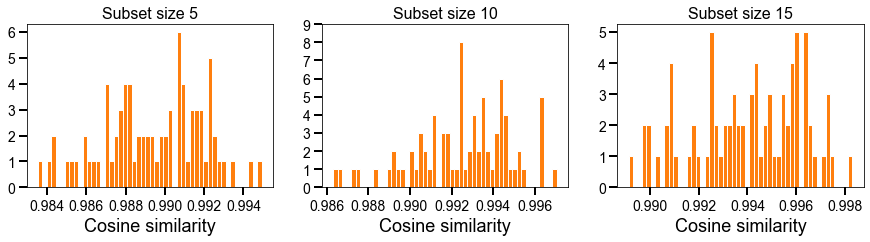

In [23]:
sizes = [5, 10, 15]
#all_scores = []

cut_indices = get_cuts(np.arange(len(Refs)), segments, sample_sizes)
cut_to_idx_map = {cut_num: cut_idxs for cut_num, cut_idxs in enumerate(cut_indices)}

ncols = len(sizes)
fig, axes = plt.subplots(figsize=(5 * ncols, 3), ncols=ncols)
plt.subplots_adjust(wspace=0.2)

for j, subset_size in enumerate(sizes):
    
    #print(f'      iteration for subset size {subset_size}', end='\r')
    #scores, hist = sample_basis(Refs, 80, subset_size, segments, sample_sizes, cut_sizes, cut_to_idx_map,
    #                            monte_carlo=False)
    #all_scores.append(scores)
    
    ax = axes[j]
    scores = all_scores[j]
    ax.hist(scores, bins=50, ec='w', fc=plt.cm.tab20(2))
    ax.set_xlabel('Cosine similarity', fontsize=18)
    ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
    ax.set_yticks(np.arange(np.max(ax.get_yticks())))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_title(f"Subset size {subset_size}", fontsize=16)

plt.savefig(f'Figures/cosine_similarity_hists_for_diff_subset_sizes.png', dpi=800,
            transparent=True, bbox_inches='tight')

### "Scree" plot
Getting the best score for each subset size.
1. How many references should we keep?

In [20]:
sizes = np.arange(3, 28, 1)
best_scores = []
cut_indices = get_cuts(np.arange(len(Refs)), segments, sample_sizes)
cut_to_idx_map = {cut_num: cut_idxs for cut_num, cut_idxs in enumerate(cut_indices)}

for subset_size in sizes:
    print(f'    iteration for subset size {subset_size}', end='\r')
    scores, hist = sample_basis(Refs, 50, subset_size, segments, sample_sizes, cut_sizes, cut_to_idx_map,
                                monte_carlo=False)
    best_scores.append(np.max(scores))

[0.9125958933562225, 0.9546273865935183, 0.9407067730541143, 0.9559706401466643, 0.9587412059954398, 0.9640486087942713, 0.9645579538753157, 0.9721526001772034, 0.9640311055992147, 0.97775447182949, 0.9747934298591391, 0.9773326642765697, 0.983789618434644, 0.9806643277157882, 0.9864460146161959, 0.9855212164591939, 0.9851714880570196, 0.9871666505350944, 0.9899430895165255, 0.9894186866092972, 0.9864755750172307, 0.9884764443730067, 0.9913175533683765, 0.9855861392145544, 0.9907796133543342]


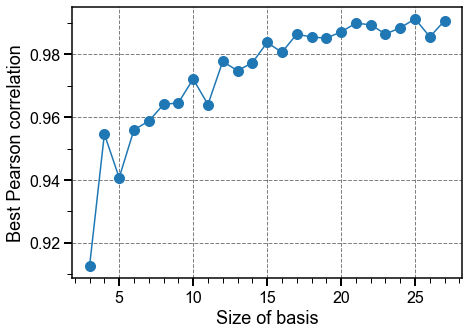

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.plot(sizes, best_scores, 'o-', markersize=10, c=plt.cm.tab20(0))

ax.set_ylabel('Best Pearson correlation', fontsize=18)
ax.set_xlabel('Size of basis', fontsize=18)

ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
ax.tick_params(direction='out', width=1, length=5, which='minor', axis='both')

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

for x in ax.get_xticks()[1:-1]:
    plt.axvline(x, linestyle='--', c='gray', linewidth=1, zorder=0)

for y in ax.get_yticks()[1:-1]:
    plt.axhline(y, linestyle='--', c='gray', linewidth=1, zorder=0)

set_spine_width(ax, width=1.5)
plt.savefig(f'Figures/Pearson_corr_vs_basis_size.png', dpi=800, transparent=True, bbox_inches='tight')

## Feature Selection: variance thresholding
Using standard sklearn feature selection. Unfortunately, this is purely internal variance within each spectrum, not in relation to the other basis elements

In [67]:
features = Refs.T

N = []
thresholds = np.arange(0.05, 0.21, 0.01)
for threshold in thresholds:
    variance_filter = VarianceThreshold(threshold=threshold)
    filtered_Refs = variance_filter.fit_transform(features)
    n = filtered_Refs.shape[1]
    N.append(n)

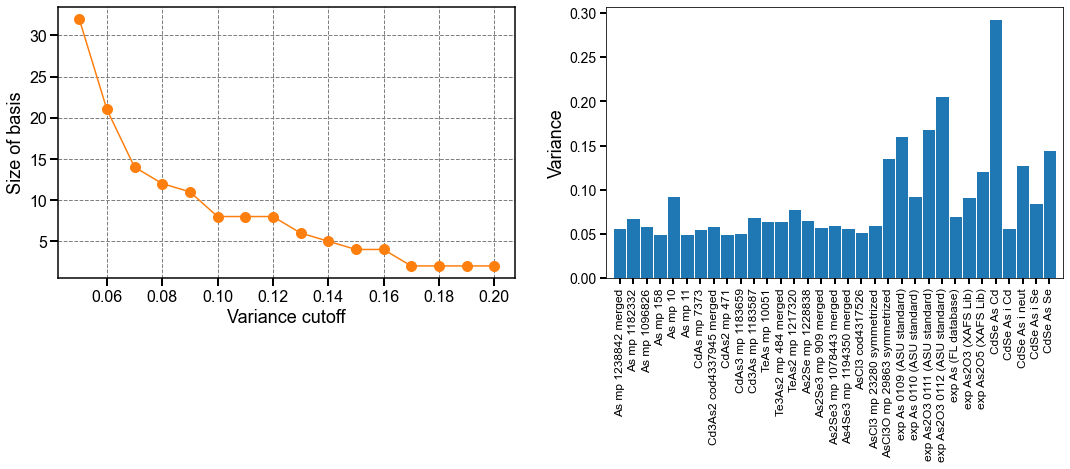

In [68]:
fig, axes = plt.subplots(figsize=(18, 5), ncols=2)

ax = axes[0]
ax.plot(thresholds, N, 'o-', markersize=10, c=plt.cm.tab20(2))

ax.set_ylabel('Size of basis', fontsize=18)
ax.set_xlabel('Variance cutoff', fontsize=18)
ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
ax.tick_params(direction='out', width=1, length=5, which='minor', axis='both')
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
for x in ax.get_xticks()[1:-1]:
    ax.axvline(x, linestyle='--', c='gray', linewidth=1, zorder=0)
for y in ax.get_yticks()[1:-1]:
    ax.axhline(y, linestyle='--', c='gray', linewidth=1, zorder=0)
set_spine_width(ax, width=1.5)

ax = axes[1]
n_feats = variance_filter.n_features_in_
ax.bar(np.arange(n_feats), variance_filter.variances_, width=1, color=plt.cm.tab20(0), edgecolor='w')
ax.tick_params(direction='out', width=2, length=6, axis='both')
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xticks(np.arange(n_feats))
ax.set_xticklabels(data_columns, fontsize=12, rotation=90)
ax.set_ylabel('Variance', fontsize=18)
ax.set_xlim((-1, n_feats))

plt.savefig(f'Figures/var_thresh_vs_basis_size.png', dpi=800, transparent=True, bbox_inches='tight')

# Correlation matrices

In [7]:
metric = 'cosine similarity'
#metric = 'Pearson correlation'
#metric = '1 - $\delta$'

In [11]:
N = len(data_columns)
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = evaluate_similarity(Refs[i], Refs[j], metric)
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score

threshold = 0.95
for i, j in itertools.product(range(N), range(N)):
    if threshold is not None:
        if Similarity_matrix[i, j] < threshold:
            Similarity_matrix[i, j] = 0

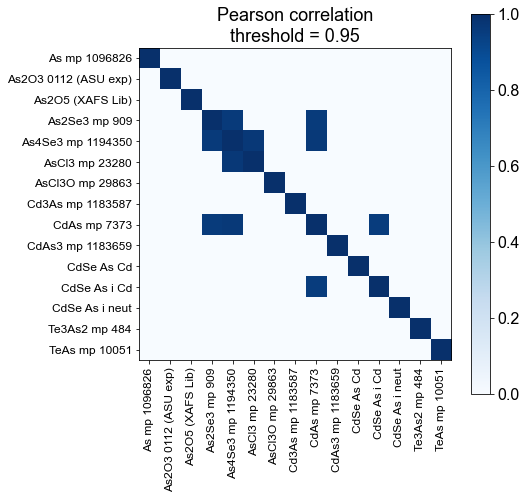

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest')
if threshold is None:
    plt.title(f'{metric}', fontsize=18)
else:
    plt.title(f'{metric}\nthreshold = {threshold}', fontsize=18)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)

ax.set_yticks(np.arange(N))
ax.set_yticklabels(data_columns, fontsize=12)

ax.set_xticks(np.arange(N))
ax.set_xticklabels(data_columns, fontsize=12, rotation=90)

metric = metric.replace('$', '').replace('\\', '')
plt.savefig(f'Figures/{metric} matrix thresh {threshold} filtered.png', dpi=800, transparent=True, bbox_inches='tight')

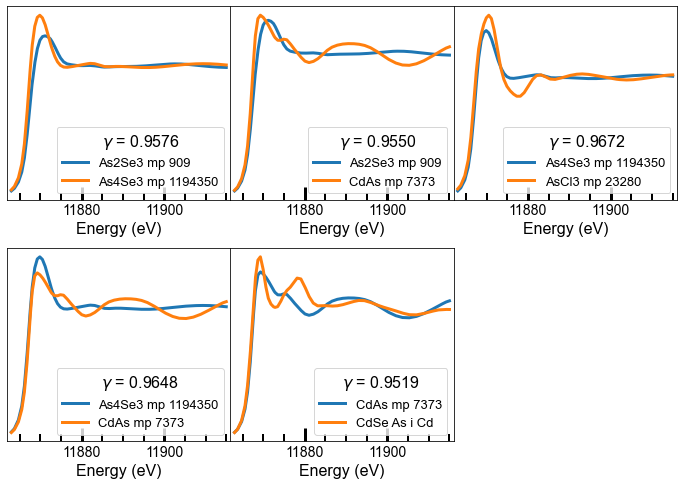

In [15]:
n = np.sum([1 for i, j in itertools.product(range(N), range(N)) if i < j
            and Similarity_matrix[i, j] != 0])
ncols = 3
nrows = n//ncols
if nrows * ncols < n:
    nrows += 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols * 4, nrows * 4))
plt.subplots_adjust(wspace=0., hspace=0.25)

k = 0
for i, j in itertools.product(range(N), range(N)):
    if i < j:
        if Similarity_matrix[i, j] != 0:
            row, colm = np.unravel_index(k, (nrows, ncols))
            ax = axes[row, colm]
            ax.plot(Energy, Refs[i], '-', linewidth=3, c=plt.cm.tab20(0),
                    label=data_columns[i].replace(' (', '\n('))
            ax.plot(Energy, Refs[j], '-', linewidth=3, c=plt.cm.tab20(2),
                    label=data_columns[j].replace(' (', '\n('))
            ax.legend(fontsize=13, loc=4, title=f'$\\theta$ = {Similarity_matrix[i, j]:.4f}',
                      title_fontsize=16)
            format_axis(ax, ticks=(5, 20), fontsize=16)
            ax.set_xlim(11862, 11916)
            k += 1

for i, j in itertools.product(range(nrows), range(ncols)):
    idx = (i * ncols) + j + 1
    if idx > n:
        axes[i, j].axis('off')

plt.savefig(f'Figures/{metric} pairing of spectra filtered.png', dpi=800, transparent=True, bbox_inches='tight')

In [17]:
hist = []
for i in range(N):
    num_nonzero = 0
    for j in range(N):
        if i < j and Similarity_matrix[i, j] != 0:
            num_nonzero += 1
    hist.append(num_nonzero)
hist = np.array(hist)

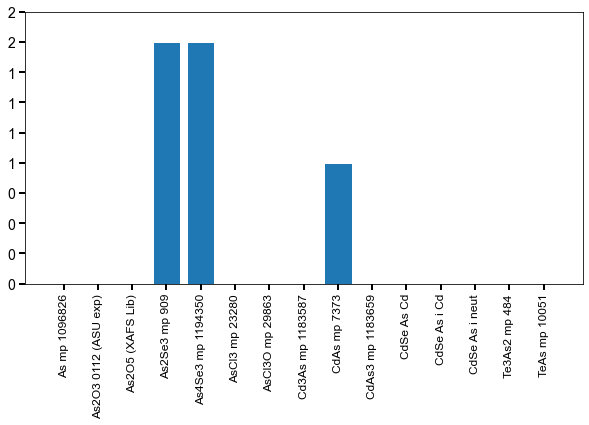

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(N), hist, color=plt.cm.tab20(0), edgecolor='w')

ax.tick_params(direction='out', width=2, length=6, axis='both')

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), fontsize=14)
ax.set_xticks(np.arange(N))
ax.set_xticklabels(data_columns, fontsize=12, rotation=90)

plt.savefig(f'Figures/histogram of matches filtered.png', dpi=800, transparent=True, bbox_inches='tight')

# Metric robustness over energy shifts

In [92]:
metrics = ['cosine similarity', 'Pearson correlation', '1 - $\delta$', '1 - IADR', '1 - MSE']
energy_shifts = np.linspace(-2, 2, 9)
start = 200
end = 5000
scores_per_metric = []

for i, ref in enumerate(Refs):
    scores_per_metric_per_ref = []
    x = ref.copy()
    for metric in metrics:
        scores = []
        for e in energy_shifts:
            interperlator = interp1d(Energy + e, x)
            y = interperlator(Energy[start:end])
            s = evaluate_similarity(x[start:end], y, metric)
            scores.append(s)
        scores_per_metric_per_ref.append(scores)
    scores_per_metric.append(scores_per_metric_per_ref)
scores_per_metric = np.array(scores_per_metric)

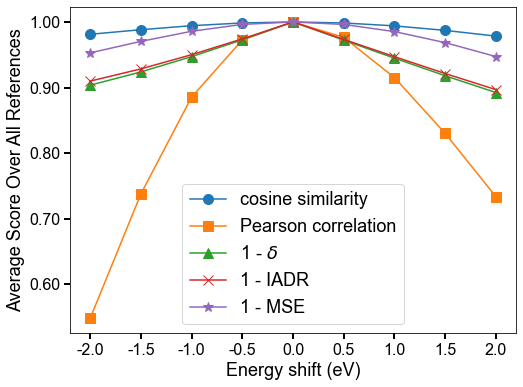

In [102]:
slice_per_ref = np.average(scores_per_metric, axis=0)
markers = ['o', 's', '^', 'x', '*']

fig, ax = plt.subplots(figsize=(8, 6))
for i, metric in enumerate(metrics):
    plt.plot(energy_shifts, slice_per_ref[i, :], marker=markers[i], 
             markersize=10, label=metrics[i])
plt.legend(fontsize=18)
    
ax.tick_params(direction='out', width=2, length=6, axis='both')
ax.set_yticks(ax.get_yticks()[1:-1])
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
ax.set_ylabel("Average Score Over All References", fontsize=18)
ax.set_xlabel("Energy shift (eV)", fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig(f'Figures/comparison_of_metrics_vs_energy_shift.png', dpi=800, transparent=True, bbox_inches='tight')

# Dendrogram

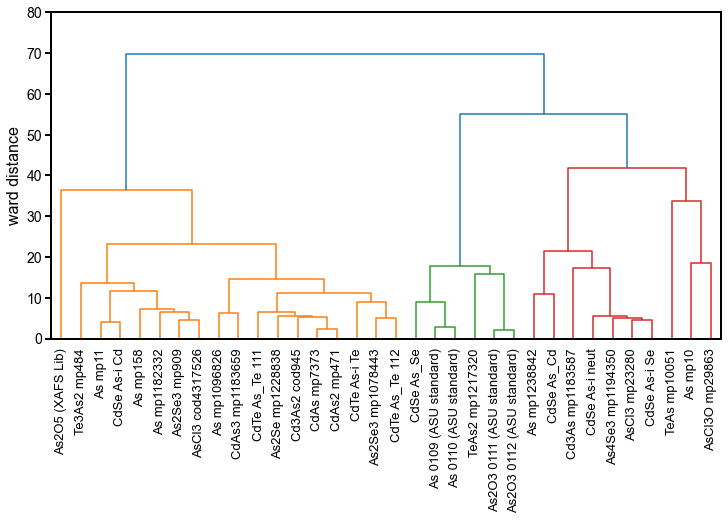

In [8]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(Refs)

fig, ax = plt.subplots(figsize=(12, 6))

def labeller(i):
    if i < len(data_columns):
        return data_columns[i]
    else:
        return i

kwargs = {'leaf_font_size': 13, 'leaf_rotation': 90, 'leaf_label_func': labeller}
plot_dendrogram(model, truncate_mode="level", p=9, **kwargs)

ax.tick_params(direction='out', width=2, length=6, axis='both')
ax.set_yticks(ax.get_yticks())
ax.set_ylabel('ward distance', fontsize=16)
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), fontsize=14)

set_spine_width(ax, 2)

plt.savefig(f'Figures/dendrogram_of_refs_filtered.png', dpi=800, transparent=True, bbox_inches='tight')

# Minimization of a reconstruction loss

In [50]:
X_energies = Energies * 1000
interperlator = interp1d(energy, refs)
Y_Refs = interperlator(X_energies)

In [51]:
#Y_Refs_filtered = np.array([Y_Refs[i] for i in selected_indices])
#Y_Refs = Y_Refs_filtered
#Y_Refs.shape

In [187]:
Y_Refs = Refs.copy()
X_energies = Energy

In [188]:
m = 10
kwargs = {'N': m, 'scale': 0.0, 'dropout': 0.99, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [189]:
indices = np.arange(test_coeffs.shape[1])
for i in range(m):
    bool_arr = test_coeffs[i] != 0
    print(indices[bool_arr])

[22]
[0]
[7]
[30]
[9]
[31]
[25]
[26]
[7]
[19]


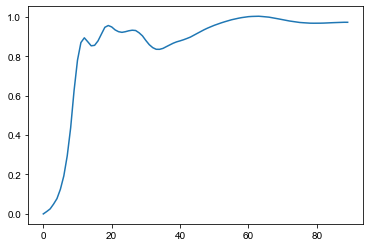

In [147]:
plt.plot(test_data[0])

## Determining the best $\lambda_1$

In [148]:
def get_spectral_loss(data, coeffs, Refs, scale=None):
    scores = []
    for i in range(data.shape[0]):
        pred = coeffs[i] @ Refs
        pred = pred.reshape(-1)
        if scale is not None:
            pred = pred * scale[i]
        pred = pred - np.min(pred)
        true = data[i]
        score = chi_square(pred, true)
        scores.append(score)
    return np.average(np.array(scores))

In [150]:
#lambdas = np.linspace(0.0, 2.0, 11)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
print(lambdas)
Unscaled_errors = {}
Scaled_errors = {}
num_contribs_unscale = {}
num_contribs_scale = {}

for lambda1 in lambdas:
    #fig, ax = plt.subplots(figsize=(4, 3))
    tol = None
    print(f'{lambda1}  ', end='\r')
    
    unscaled_coeffs, _ = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False, tol=tol,
                                                 lambda1=lambda1, return_sigmas=False)
    
    #pred = unscaled_coeffs @ Y_Refs
    #pred = pred.reshape(-1)
    #pred = pred - np.min(pred)
    #ax.plot(pred, c=plt.cm.tab20(0), label='unscaled')
    
    unscale_err = get_spectral_loss(test_data, unscaled_coeffs, Y_Refs, scale=None)
    Unscaled_errors[lambda1] = unscale_err
    
    num_contribs_unscale[lambda1] = np.average(np.sum(unscaled_coeffs[i] != 0))

    scale, scaled_coeffs, _ = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True, tol=tol,
                                                      lambda1=lambda1, return_sigmas=False)
    #pred = scaled_coeffs @ Y_Refs
    #pred = pred.reshape(-1)
    #pred = pred * scale
    #pred = pred - np.min(pred)
    #ax.plot(pred, c=plt.cm.tab20(2), label='scaled')
    
    #ax.plot(test_data[0], c=plt.cm.tab20(14), label='target')
    #ax.legend(fontsize=16)
    #plt.show()
    
    scale_err = get_spectral_loss(test_data, scaled_coeffs, Y_Refs, scale=scale)
    Scaled_errors[lambda1] = scale_err
    num_contribs_scale[lambda1] = np.average(np.sum(scaled_coeffs != 0, axis=1), axis=0)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


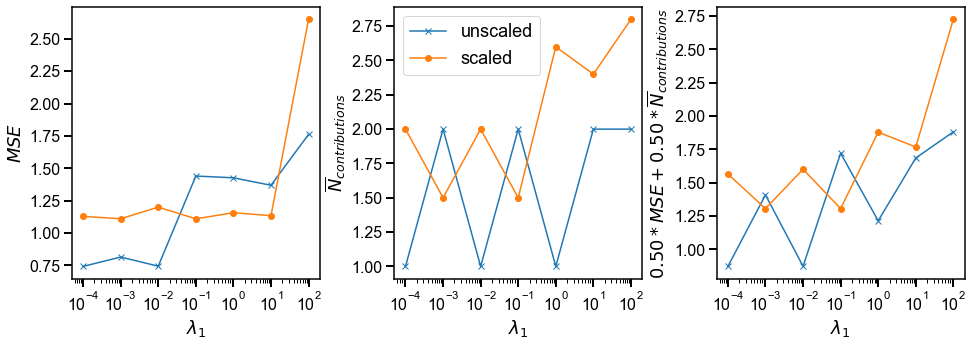

In [151]:
fig, axes = plt.subplots(figsize=(5*3 + 1, 5), ncols=3)
plt.subplots_adjust(wspace=0.3)
plot_error_vs_lambda((fig, axes), Unscaled_errors, Scaled_errors, num_contribs_unscale, num_contribs_scale, p=0.5)
for ax in axes:
    ax.tick_params(direction='out', width=1, length=4, which='minor', axis='both')
    ax.set_xscale('log')
plt.savefig(f'Figures/determining_lambda1_log.png', dpi=800, bbox_inches='tight', transparent=True)

# Monte Carlo

In [179]:
def chi_square(data, fit):
    return np.sum((data - fit)**2)

def reduced_chi_square(data, fit, m):
    dof = len(data) - m - 1
    return chi_square(data, fit) / dof
    
def R_score(data, fit):
    return np.sum((data - fit)**2) / np.sum(data**2)

In [180]:
def get_goodness_of_fit_from_subset(subset, target, metric, ax=None):
    scale, coeffs_hat, _ = get_coeffs_from_spectra([target], subset, scaling=True, tol=None,
                                                   lambda1=0.1, lambda2=1e8)
    recon = coeffs_hat @ subset
    recon = recon.reshape(-1)
    recon = recon - np.min(recon)
    score = reduced_chi_square(target, recon, len(subset))
    
    if ax is not None:
        ax.plot(recon, c=plt.cm.tab20(2), label='recon')
        ax.plot(target, c=plt.cm.tab20(14), label='target')
        #ax.legend()
        ax.set_yticks([])
        ax.set_xticks([])
        
        R = R_score(target, recon)
        chi2 = reduced_chi_square(target, recon, subset_size)
        xs = ax.get_xlim()
        ys = ax.get_ylim()
        label = '$\chi^2_\\nu = $' + f'{chi2:.03f}' # + f'\nR = {R:.3f}'
        ax.text(0.45 * (xs[1] - xs[0]) + xs[0], 0.2 * (ys[1] - ys[0]) + ys[0], label, 
                fontsize=12)
    
    return score

In [241]:
def monte_carlo_sample_subset(basis, set_tuple, target, metric, beta, probs, verbose=False):
    
    subset, subset_indices, non_subset, non_subset_indices = set_tuple
    
    test_subset_indices = subset_indices.copy()
    replace_subset_i = np.random.randint(0, high=len(subset_indices))
    test_basis_i = np.random.randint(0, high=len(non_subset_indices))
    test_subset_indices[replace_subset_i] = subset_indices[test_basis_i]
    
    test_subset, test_non_subset_indices, test_non_subset = get_sets_from_subset_indices(test_subset_indices, basis)
    
    score = get_goodness_of_fit_from_subset(subset, target, metric)
    test_score = get_goodness_of_fit_from_subset(test_subset, target, metric)
    
    delta_u = test_score - score
    
    if test_score > score:
        probs.append(np.exp(-beta * delta_u))

    if test_score < score:
        if verbose:
            print('Replacing')
        return (test_subset, test_subset_indices, test_non_subset_indices, test_non_subset), test_score
    elif test_score > score and np.random.random() < np.exp(-beta * delta_u):
        if verbose:
            print(f'P={np.exp(-beta * delta_u)}')
            print(f'Replacing cuz T')
        return (test_subset, test_subset_indices, test_non_subset_indices, test_non_subset), test_score
    else:
        if verbose:
            print("Keeping")
        return (subset, subset_indices, non_subset_indices, non_subset), score

In [242]:
def LCF(basis, target, num_iters, subset_size, verbose=False, monte_carlo=True,
        metric='cosine similarity', beta=1000, step_size=700):
    indices = np.arange(basis.shape[0])
    scores = []
    probs = []
    
    if monte_carlo:
        temp_set_tuple = None
        for i in range(num_iters):
            print(i + 1, end='\r')
            if i == 0:
                subset_indices = np.random.choice(indices, size=subset_size, replace=False)
                subset, non_subset_indices, non_subset = get_sets_from_subset_indices(subset_indices, basis) 
                temp_set_tuple = (subset, subset_indices, non_subset, non_subset_indices)
            else:
                set_tuple, score = monte_carlo_sample_subset(basis, temp_set_tuple, target, metric, beta, probs,
                                                             verbose=verbose)
                temp_set_tuple = set_tuple
                beta =+ step_size
                scores.append(score)
                #_, subset_indices, _, _ = set_tuple
        subset, subset_indices, _, _ = temp_set_tuple
        best_score = scores[-1]
    else:
        best_score = np.inf
        best_subset_indices = np.zeros(subset_size)
        i = 0
        
        if subset_size < 2:
            Nk = comb(len(indices), subset_size)
            ncols = 10
            nrows = int(Nk // ncols)
            if nrows * ncols < Nk:
                nrows += 1
            fig, axes = plt.subplots(figsize=(2 * ncols, 2 * nrows), ncols=ncols, nrows=nrows)
            plt.subplots_adjust(wspace=0, hspace=0)
        
        for subset_indices in itertools.combinations(indices, subset_size):
            print(i + 1, end='\r')
            subset_indices = np.array(subset_indices)
            subset, non_subset_indices, non_subset = get_sets_from_subset_indices(subset_indices, basis) 
            set_tuple = (subset, subset_indices, non_subset, non_subset_indices)
            
            if subset_size < 2:
                row, colm = np.unravel_index(i, (nrows, ncols))
                ax = axes[row, colm]
                score = get_goodness_of_fit_from_subset(subset, target, metric, ax=ax)
            else:  
                score = get_goodness_of_fit_from_subset(subset, target, metric)
            if score < best_score:
                best_score = score.copy()
                best_subset_indices = subset_indices.copy()        
            i += 1
        
        if subset_size < 2:
            for i in np.arange(Nk, nrows * ncols):
                i = int(i)
                row, colm = np.unravel_index(i, (nrows, ncols))
                ax = axes[row, colm]
                ax.axis('off')
            
        subset_indices = best_subset_indices
        subset, _, _ = get_sets_from_subset_indices(subset_indices, basis)
    
    print(subset_indices, best_score)
    scale, coeffs_hat, _ = get_coeffs_from_spectra([target], subset, scaling=True, tol=None,
                                                    lambda1=0.1, lambda2=1e8)
    if verbose:
        print()
    return subset_indices, subset, scale, coeffs_hat, best_score, probs

In [243]:
m = 2
kwargs = {'N': m, 'scale': 0.0, 'dropout': 0.99, 'training': False}
Y_Refs = Refs.copy()[:5]
X_energies = Energy
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [244]:
basis = Y_Refs
num_iters = 100
subset_size = 3
subsets = []
scales = []
coeffs = []
scores = []

#fig, ax = plt.subplots(figsize=(6, 4))
for j in range(m):
    print(f"Target {j + 1}")
    target = test_data[j]
    subset_indices, subset, scale, coeffs_hat, score, probs = LCF(basis, target, num_iters, subset_size,
                                                                  verbose=False, monte_carlo=True)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)
    
    #ax.plot(np.arange(len(probs)), probs, label=f'Target {i + 1}')
#plt.legend()
#plt.show()

Target 1
[1 1 2] 0.0004931821669106098
Target 2
[1 4 1] 2.169537590436286e-13


In [245]:
print([sum(test_coeffs[i] != 0) for i in range(m)])
print()
indices = np.arange(test_coeffs.shape[1])
for i in range(m):
    bool_arr = test_coeffs[i] != 0
    print(indices[bool_arr])

[2, 1]

[1 2]
[4]


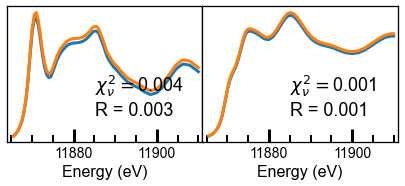

In [246]:
fig, axes = plt.subplots(figsize=(3.5 * m, 2.5), ncols=m)
plt.subplots_adjust(wspace=0)

preds = []
for i in range(m):
    pred = scales[i] * coeffs[i] @ subsets[i]
    pred = pred - np.min(pred)
    preds.append(pred.reshape(-1))
preds = np.array(preds)   
    
for i, ax in enumerate(axes):
    ax.plot(X_energies, preds[i], linewidth=3, label='fit')
    ax.plot(X_energies, test_data[i], linewidth=3, label='target')
    
    ax.set_yticks([])
    format_axis(ax, ticks=(5, 20), fontsize=16)
    ax.set_xlim(11864, 11911)
    set_spine_width(ax, width=1.3) 
    R = R_score(test_data[i], preds[i])
    chi2 = reduced_chi_square(test_data[i], preds[i], subset_size)
    xs = ax.get_xlim()
    ys = ax.get_ylim()
    label = '$\chi^2_\\nu = $' + f'{chi2:.03f}' + f'\nR = {R:.3f}'
    ax.text(0.45 * (xs[1] - xs[0]) + xs[0], 0.2 * (ys[1] - ys[0]) + ys[0], label, 
            fontsize=18)

    #if i == m - 1:
    #    ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')

## Tolerancing

In [328]:
kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.9, 'training': False}
Y_Refs = Refs.copy()
X_energies = Energy
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [329]:
utils = reload(utils)
from utils import *

In [330]:
tol = 0.00
metric = 'mean_squared_error'
lambda1 = 0
unscaled_coeffs, un_sigs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False, tol=tol,
                                                   lambda1=lambda1)
scale, scaled_coeffs, sc_sigs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True, tol=tol,
                                                        lambda1=lambda1)
coeffs = np.array([test_coeffs, unscaled_coeffs, scaled_coeffs])

In [331]:
Y_Refs.shape, test_data.shape, unscaled_coeffs.shape, X_energies.shape

((34, 90), (5, 90), (5, 34), (90,))

mean squared error: 0.015730812370842624
mean squared error: 0.010301628355787852


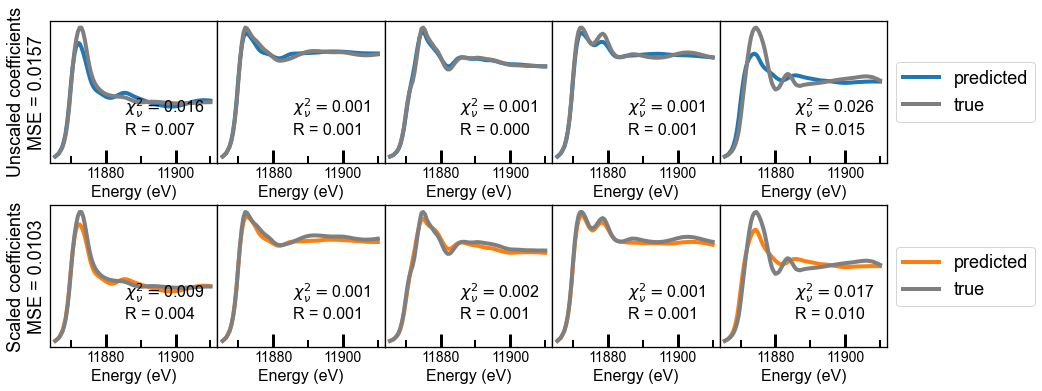

In [335]:
m = 5
fig, axes = plt.subplots(figsize=(3 * m, 3 * 2), ncols=m, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0.3)

unscaled_error = plot_reconstructions((fig, axes[0, :]), test_data, coeffs[1], m, X_energies,
                                       Y_Refs, metric=metric, color=0)
scaled_error = plot_reconstructions((fig, axes[1, :]), test_data, coeffs[2], m, X_energies,
                                     Y_Refs, scale=scale, metric=metric, color=2)

axes[0, 0].set_ylabel(f'Unscaled coefficients\nMSE = {unscaled_error:.4f}', fontsize=18)
axes[1, 0].set_ylabel(f'Scaled coefficients\nMSE = {scaled_error:.4f}', fontsize=18)

for i in range(axes.shape[0]):
    fit = np.array([x - np.min(x) for x in coeffs[i + 1] @ Y_Refs])
    if i == 1:
        fit = np.array([f * scale[i] for i, f in enumerate(fit)])
    for j in range(axes.shape[1]):
        set_spine_width(axes[i, j], width=1.3) 
        R = R_score(test_data[j], fit[j])
        chi2 = reduced_chi_square(test_data[j], fit[j])
        axes[i, j].set_xlim(11864, 11912)
        xs = axes[i, j].get_xlim()
        ys = axes[i, j].get_ylim()
        label = '$\chi^2_\\nu = $' + f'{chi2:.03f}' + f'\nR = {R:.3f}'
        axes[i, j].text(0.45 * (xs[1] - xs[0]) + xs[0], 0.2 * (ys[1] - ys[0]) + ys[0], label, 
                       fontsize=16)

plt.savefig(f'Figures/unscaled_vs_scaled_recon_spectra_tol_{tol}_lambda1_{lambda1}.png',
            dpi=800, bbox_inches='tight', transparent=True)

## The problems with $\chi^2_\nu$:
1. More references than data points $\longrightarrow$ underconstrained fitting
2. Not knowing uncertainties for each measurement $\longrightarrow$ overestimate errors $\longrightarrow$ too small $\chi^2_\nu$
3. Maximizing likelihood function is only equivalent to minimizing $\chi^2$ if $x_i$ ~$\mathcal{N}(0, \sigma_i^2)$

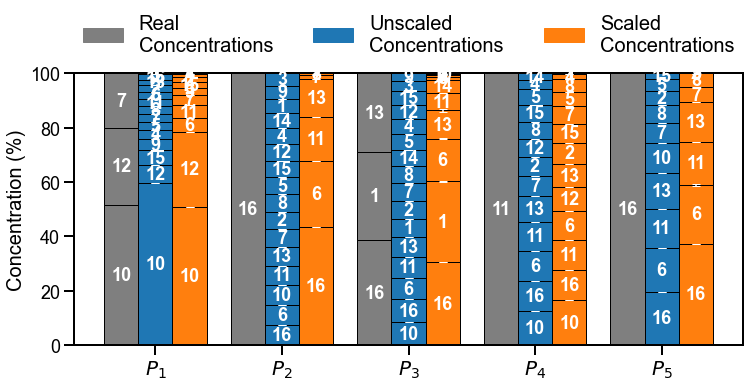

In [233]:
fig, ax = plt.subplots(figsize=(4*3, 5))
titles = ['Real\nConcentrations', 'Unscaled\nConcentrations', 'Scaled\nConcentrations']
width = 0.27
offsets = [-width, 0, width]
colors = [14, 0, 2]
sigs = [None, un_sigs, sc_sigs]

for i in range(3):
    if i == 2:
        ft = True
    else:
        ft = False
    make_conc_bar_chart((fig, ax), coeffs[i], data_columns, sigs[i], width=width,
                         offset=offsets[i], varcolor=colors[i], format_ticks=ft)
patches = [mpatches.Patch(color=plt.cm.tab20(colors[i]), label=titles[i]) for i in range(3)]
legend = ax.legend(handles=patches, frameon=False, fontsize=20, ncol=3,
                   loc='lower center', bbox_to_anchor=(0.5, 1.))
ax.set_ylim(0, 100)   
plt.savefig(f'Figures/coeff_bar_chart_tol_{tol}.png', dpi=800, bbox_inches='tight', transparent=True)

In [234]:
coeffs.shape, test_data.shape, Y_Refs.shape

((3, 5, 16), (5, 9), (16, 9))

Total chi square: 1.033690148582276
Single chi square: 0.023425365480746738
R = 0.0025633065044203484


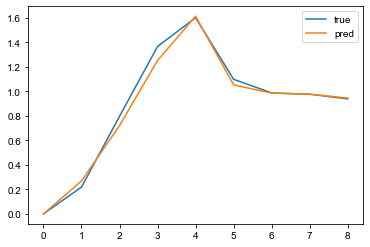

In [236]:
preds = coeffs[1] @ Y_Refs
predictions = np.array([pred - np.min(pred) for pred in preds])
print(f'Total chi square: {chi_square(test_data, predictions)}')

i = 0
y = test_data[i]
yhat = predictions[i]
plt.plot(y, label='true')
plt.plot(yhat, label='pred')
plt.legend()

print(f'Single chi square: {chi_square(y, yhat)}')
print(f'R = {R_score(y, yhat)}')

In [185]:
X = Y_Refs
tol = 1e8
C = np.linalg.inv(X @ X.T + np.identity(Y_Refs.shape[0]) * tol)
#print(np.diag(C))
S = np.sum((test_data - predictions)**2)
#print(S)
n = Y_Refs.shape[1]  # number observations, or energies
m = 1  # number constraints (add to one)
nu = n - m
sigma2 = S / nu
#print(sigma2)
print(sigma2 * np.diag(C))

[2.10432939e-09 2.10432955e-09 2.10432936e-09 2.10432950e-09
 2.10432955e-09 2.10432960e-09 2.10432956e-09 2.10432956e-09
 2.10432941e-09 2.10432954e-09 2.10432960e-09 2.10432950e-09
 2.10432959e-09 2.10432949e-09 2.10432952e-09 2.10432960e-09]


In [186]:
gammainc(0.5 * nu, 0.5 * chi_square(test_data, predictions))

0.010773095062626562

## Analyze affect of noise on error

In [137]:
metric = 'mean_squared_error'
lambda1 = 0.
noises = np.arange(0, 0.06, 0.01)
Errors = get_errors_with_different_noises(Y_Refs , noises=noises, metric=metric, lambda1=lambda1)

Noise: 0.0%
Noise: 1.0%
Noise: 2.0%
Noise: 3.0%
Noise: 4.0%
Noise: 5.0%


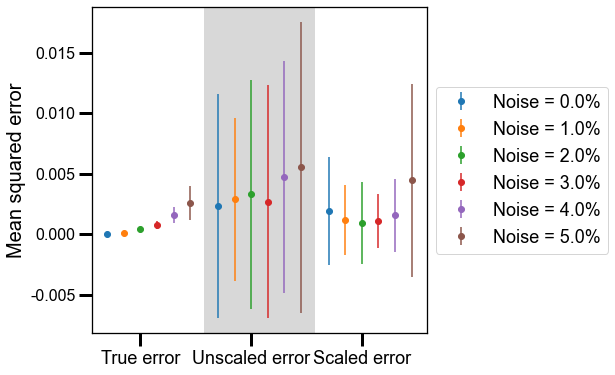

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['True error', 'Unscaled error', 'Scaled error']
ax.axvspan(0.875, 1.875, fc=plt.cm.tab10(7), alpha=0.3)

for i, noise in enumerate(noises):
    errors = Errors[i]
    for j in range(errors.shape[0]):
        err = errors[j, :]
        if j == 0:
            label = f"Noise = {noise * 100}%"
        else:
            label = None
        plt.errorbar(np.array([j]) + i*0.15, np.average(err), yerr=np.std(err), fmt='o',
                     color=plt.cm.tab10(i), label=label)
        
plt.legend(fontsize=18, bbox_to_anchor=(1., 0.5), loc='center left')

ax.tick_params(direction='out', width=3, length=13, which='major', axis='both')

ax.set_ylabel('Mean squared error', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=16)

x_pos = np.array([i + 0.3 for i, _ in enumerate(labels)])
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.xticks(x_pos, labels, fontsize=18)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
set_spine_width(ax, width=1.3)

plt.savefig('Figures/minimization_optimization_noise_error.png', dpi=800,
            bbox_inches='tight', transparent=True)

# Find coeffs of experimental data using minimimzation with scaling

In [24]:
utils = reload(utils)
from utils import *

Set 1
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
Set 2
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
Set 3
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
mean squared error: 0.0439187370881641
Set 4
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
Set 5
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...


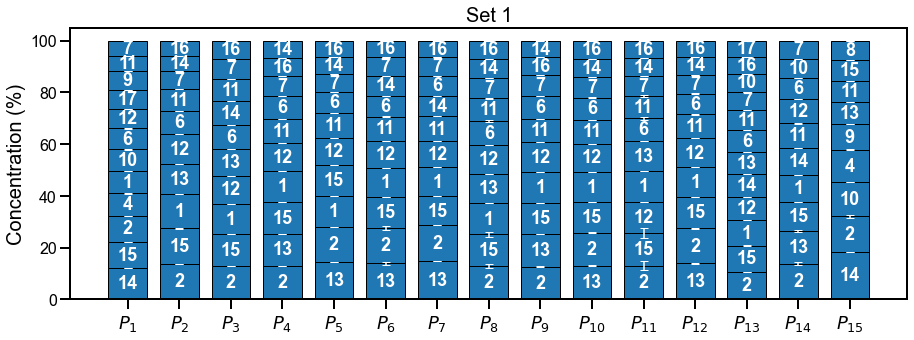

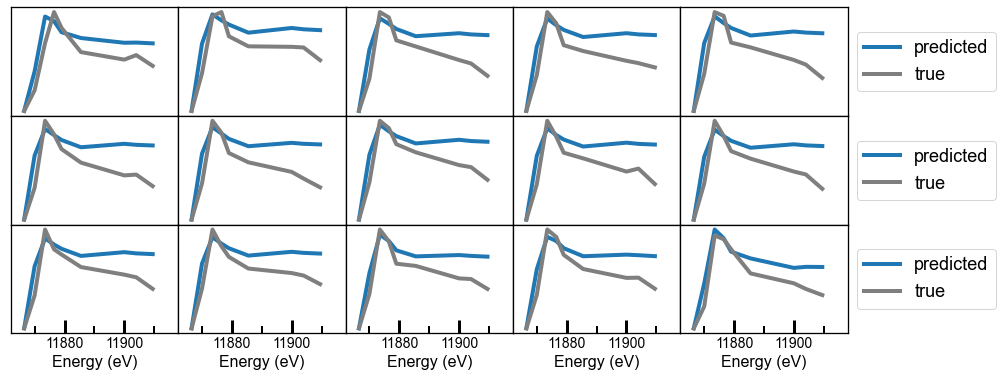

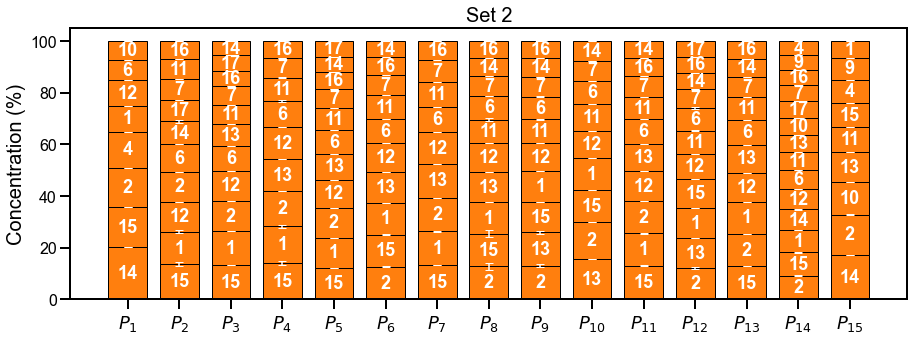

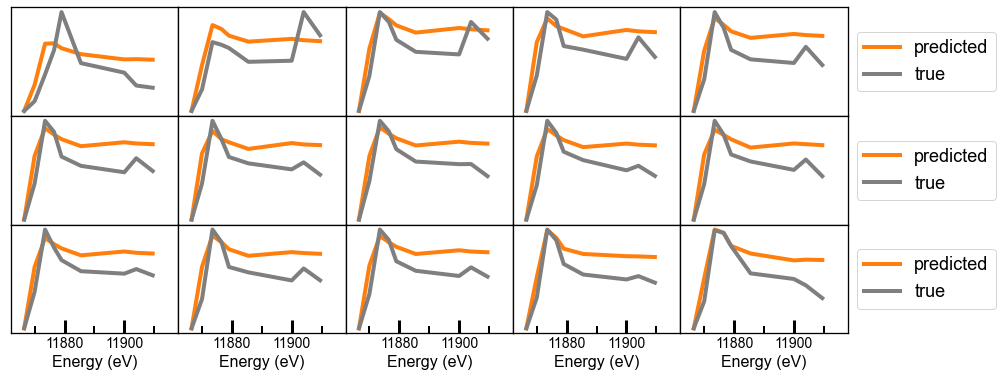

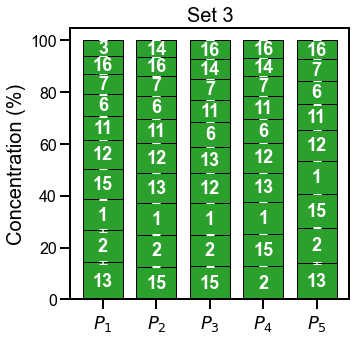

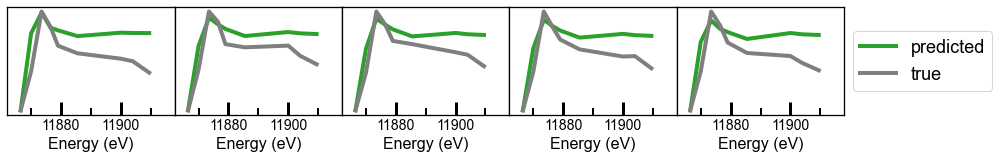

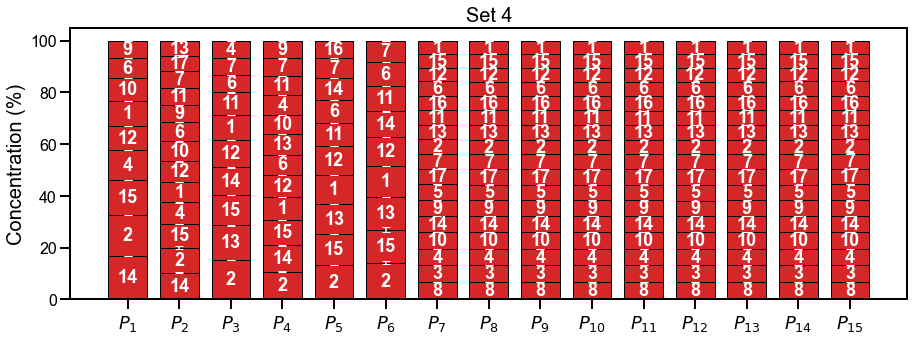

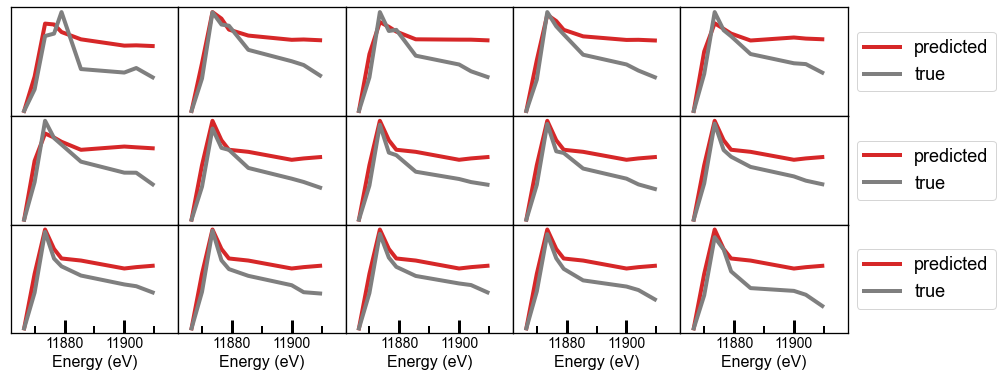

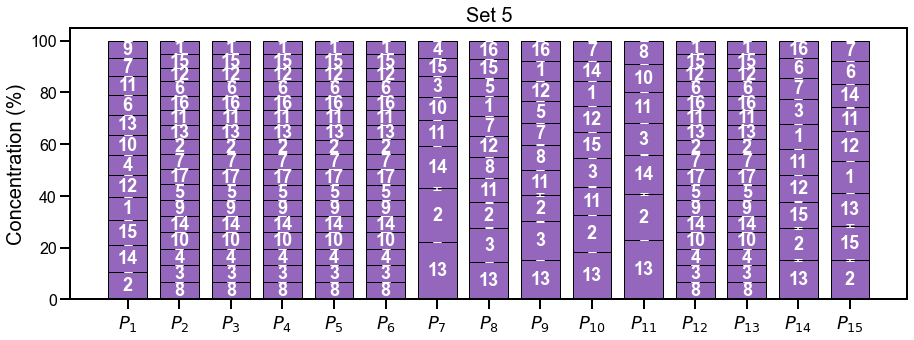

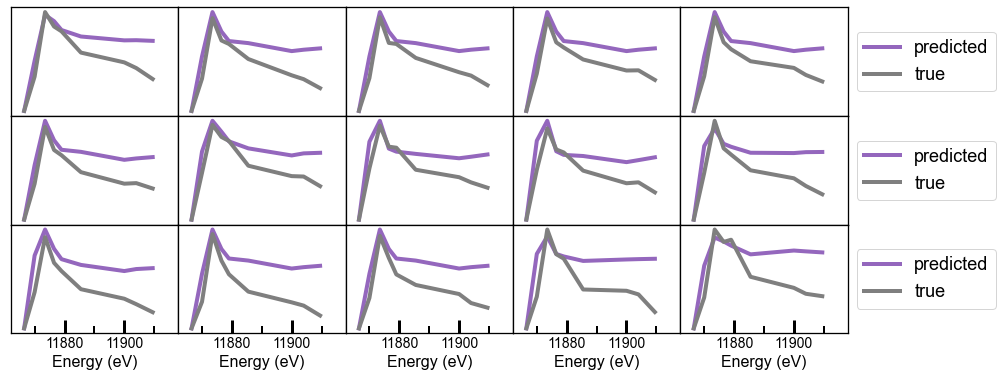

In [27]:
#for Set in range(1, 6):
for Set in [1, 2, 3, 4, 5]:
    print(f'Set {Set}')
    setdata = DATA[Set]
    Spectra = []
    for i, pt in enumerate(setdata):
        spectrum = np.array(pt['I'], dtype=float)
        spectrum = spectrum / np.max(spectrum)
        Spectra.append(spectrum)
    Spectra = np.array(Spectra)
    print('Getting coeffs...')
    
    Scales, Coeffs, Sigmas = get_coeffs_from_spectra(Spectra, Y_Refs, scaling=True,
                                                     lambda1=0.3, tol=0.05)
    print('Setting up bar chart...')

    fig, ax = plt.subplots(figsize=(len(setdata), 5))
    plt.subplots_adjust(wspace=0, hspace=0.25)
    
    make_conc_bar_chart((fig, ax), Coeffs, data_columns, Sigmas, width=0.75,
                        varcolor=(Set - 1)*2, format_ticks=False)
       
    m = Coeffs.shape[0]
    labels = ["$" + "P_{" + f"{i}" + "}$" for i in range(1, m + 1)]
    ax.set_xticks(np.arange(0, m))
    ax.set_xticklabels(labels, fontsize=18)
    
    plt.setp(ax.get_yticklabels(), fontsize=16)
    
    plt.title(f'Set {Set}', fontsize=20)
    plt.savefig(f'Figures/Set_{Set}_coeff_bar_chart.png', dpi=800, transparent=True)

    print('Setting up reconstruction plot...')
    
    m = 5
    N = len(Spectra)
    nrows = N//m
    fig, axes = plt.subplots(figsize=(5*ncols, 2*nrows), ncols=m, nrows=nrows)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if len(axes.shape) == 2:
        Spectra = Spectra.reshape(axes.shape[0], axes.shape[1], -1)
        Coeffs = Coeffs.reshape(axes.shape[0], axes.shape[1], -1)
        Scales = Scales.reshape(axes.shape[0], axes.shape[1], -1)
    else:
        Spectra = Spectra.reshape(axes.shape[0], -1)
        Coeffs = Coeffs.reshape(axes.shape[0], -1)
        Scales = Scales.reshape(axes.shape[0], -1)

    if len(axes.shape) == 2:
        for i in range(axes.shape[0]):
            err = plot_reconstructions((fig, axes[i, :]), Spectra[i], Coeffs[i], m, X_energies,
                                        Y_Refs, scale=Scales[i], color=(Set - 1)*2, verbose=False)
            
            for j in range(axes.shape[1]):
                if i != axes.shape[0] - 1:
                    axes[i, j].set_ylabel(None)
                    axes[i, j].set_xticks([])
                    axes[i, j].set_yticks([])
                else:
                    format_axis(axes[i, j], ticks=(10, 20), fontsize=16)
                set_spine_width(axes[i, j], width=1.3)
                axes[i, j].set_xlim(11862, 11918)
    else:
        err = plot_reconstructions((fig, axes), Spectra, Coeffs, m, X_energies,
                                    Y_Refs, scale=Scales, color=(Set - 1)*2)
        for j in range(axes.shape[0]):
            format_axis(axes[j], ticks=(10, 20), fontsize=16)
            set_spine_width(axes[j], width=1.3)
            axes[j].set_xlim(11862, 11918)

    plt.savefig(f'Figures/Set_{Set}_recon_plot.png', dpi=800, bbox_inches='tight', transparent=True)